In [19]:
#Imports

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

from math import sqrt



# Data Processing

In [20]:
df = pd.read_csv("abalone.data", names=["sex", "length", "diameter", "height", "whole weight", "shucked weight",
                                       "viscera weight", "shell weight", "rings"])

df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Since our target is age, we must convert the rings column to age by adding 1.5 to every entry, since abalone show age similarly to trees.

In [21]:
df["age"] = df["rings"] + 1.5
df = df.drop(columns = "rings")

df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [22]:
sexArr = df["sex"].to_numpy()
numRows = len(sexArr)

sexMat = np.zeros((numRows, 3), dtype=int)
for i in range(numRows):
    char = sexArr[i]
    if char == 'M':
        sexMat[i][0] = 1
    elif char == 'F':
        sexMat[i][1] = 1
    else:
        sexMat[i][2] = 1

sexdf = pd.DataFrame(data = sexMat, columns = ["M", "F", "I"])

df = pd.concat([sexdf, df], axis = 1, sort = False)
df = df.drop(columns = "sex")

df.head()

,M,F,I,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,age
0,1,0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,1,0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,1,0,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


# Exploratory Data Analysis

Quick Info

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   M               4177 non-null   int32  
 1   F               4177 non-null   int32  
 2   I               4177 non-null   int32  
 3   length          4177 non-null   float64
 4   diameter        4177 non-null   float64
 5   height          4177 non-null   float64
 6   whole weight    4177 non-null   float64
 7   shucked weight  4177 non-null   float64
 8   viscera weight  4177 non-null   float64
 9   shell weight    4177 non-null   float64
 10  age             4177 non-null   float64
dtypes: float64(8), int32(3)
memory usage: 310.1 KB


Dataset Size

In [24]:
no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

No. of Rows: 4177
No. of Columns: 11


Visualizing Data Using Histograms

array([[<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'I'}>],
       [<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'diameter'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'whole weight'}>,
        <AxesSubplot:title={'center':'shucked weight'}>,
        <AxesSubplot:title={'center':'viscera weight'}>],
       [<AxesSubplot:title={'center':'shell weight'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

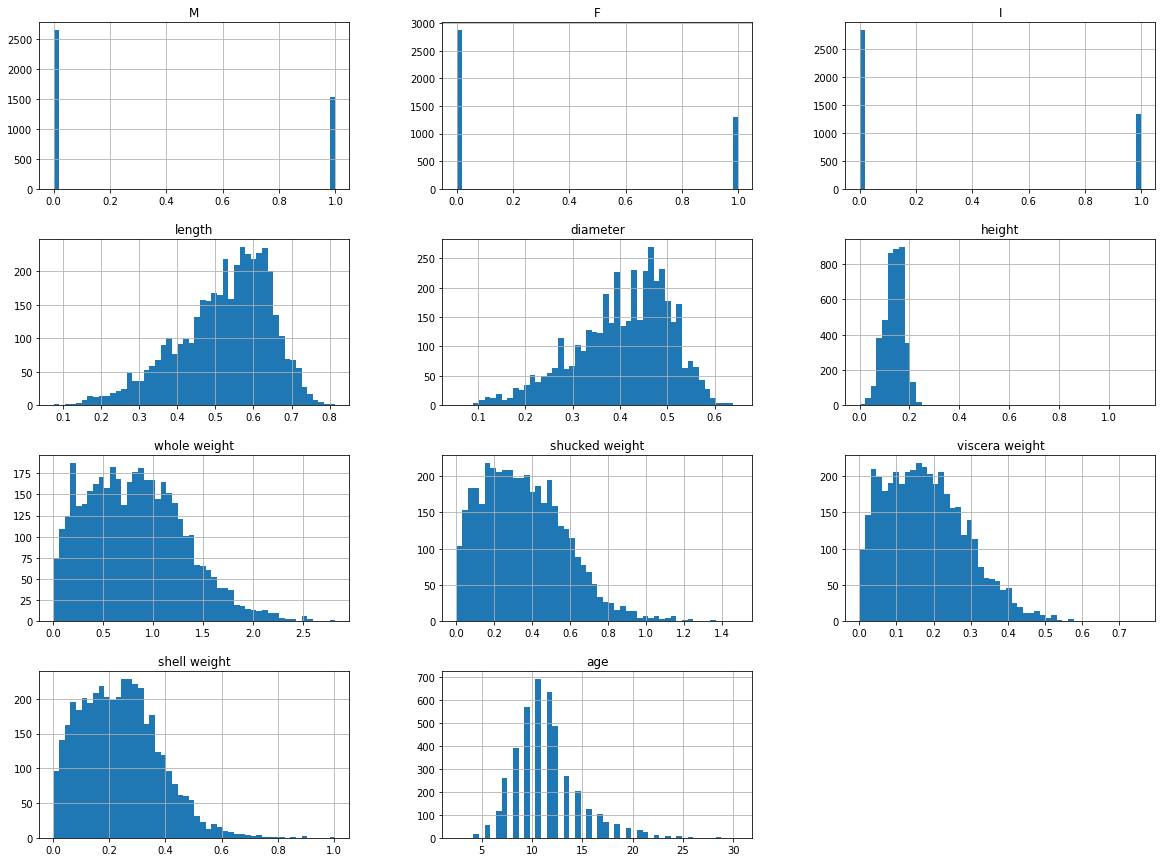

In [25]:
df.hist(bins=50, figsize=(20,15))

In [47]:
df.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,age
count,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000
mean,0.508243,0.394458,0.134111,0.742999,0.328251,0.164091,0.214736,10.944846
std,0.117148,0.096347,0.040232,0.436109,0.205401,0.100427,0.123063,2.801612
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.435000,0.335000,0.110000,0.395000,0.167000,0.083250,0.117500,9.500000
50%,0.525000,0.405000,0.135000,0.708500,0.302000,0.153500,0.209000,10.500000
75%,0.600000,0.470000,0.160000,1.053000,0.465250,0.231750,0.300000,12.500000
max,0.775000,0.630000,1.130000,2.779500,1.348500,0.760000,1.005000,24.500000


Checking Correlation with Target Feature

In [27]:
df.corr()['age'].sort_values(ascending=False)

age               1.000000
shell weight      0.627574
diameter          0.574660
height            0.557467
length            0.556720
whole weight      0.540390
viscera weight    0.503819
shucked weight    0.420884
F                 0.250279
M                 0.181831
I                -0.436063
Name: age, dtype: float64

Seaborn Pair Plot

In [28]:
# Comment out to save time

"""
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

g = sns.PairGrid(df)

g.map_upper(plt.scatter, s=10, color = 'red')

g.map_diag(sns.distplot, kde=False, color = 'red')

g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);
"""

'\ndef corrfunc(x, y, **kws):\n    r, _ = stats.pearsonr(x, y)\n    ax = plt.gca()\n    ax.annotate("r = {:.2f}".format(r),\n                xy=(.1, .6), xycoords=ax.transAxes,\n               size = 24)\n    \ncmap = sns.cubehelix_palette(light=1, dark = 0.1,\n                             hue = 0.5, as_cmap=True)\n\nsns.set_context(font_scale=2)\n\ng = sns.PairGrid(df)\n\ng.map_upper(plt.scatter, s=10, color = \'red\')\n\ng.map_diag(sns.distplot, kde=False, color = \'red\')\n\ng.map_lower(sns.kdeplot, cmap = cmap)\ng.map_lower(corrfunc);\n'

# Data Preprocessing

Create new columns for the ratios and error.

In [29]:
df['viscera/w'] = df['viscera weight']/df['whole weight']
df['shucked/w'] = df['shucked weight']/df['whole weight']
df['shell/w']   = df['shucked weight']/df['whole weight']
df['err']       = abs(df['shucked weight']+df['shell weight']+df['viscera weight']-df['whole weight'])


then we graph the distribution of the data using the new columns we got.

KeyError: 'M'

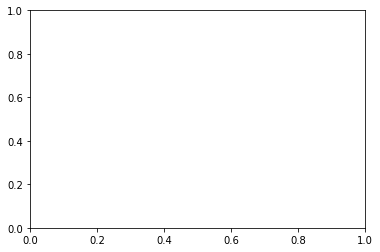

In [46]:
 def graph_lable(lable):
    a = plt.gca()
    df.loc[df['M']==1].plot(kind='scatter',x = 'age',y = lable,color='red',ax=a)
    df.loc[df['F']==1].plot(kind='scatter',x = 'age',y = lable,color='blue',ax=a)
    df.loc[df['I']==1].plot(kind='scatter',x = 'age',y = lable,color='green',ax=a)
    plt.show()
graph_lable('err')
graph_lable('viscera/w')
graph_lable('shucked/w')
graph_lable('shell/w')


In [31]:
bad_data    =  [set(df[df['err']>0.1].index),
                set(df[df['shucked/w']>0.6].index),
                set(df[df['shell/w']>0.56].index),
                set(df[df['viscera/w']>0.4].index)]
union       = set().union(*bad_data)
df = df.drop(union)

In [32]:
print(df.corr().abs()['age'].sort_values(ascending=False))
df = df.drop(columns=['F','M','I','viscera/w','shucked/w','shell/w','err'])


age               1.000000
shell weight      0.615389
diameter          0.579821
length            0.563341
height            0.548349
err               0.530251
whole weight      0.523393
viscera weight    0.502288
I                 0.435073
shucked weight    0.431871
F                 0.259732
shell/w           0.228436
shucked/w         0.228436
M                 0.190985
viscera/w         0.015461
Name: age, dtype: float64


In [97]:
df = df.sample(frac=1)

y = df['age'].to_numpy()
X = df.drop(columns='age').to_numpy()

poly = PolynomialFeatures(2)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Probably do some PCA/standardiazation/polynomial features or something here

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Models

## Linear Regression Using Stochastic Gradient Descent

In [17]:
'''
param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal", "invscaling"], 
              'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],'eta0': [0.01, 0.001],
              'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
'''

param_grid = {'alpha': [0.01, 0.001, .00001], 'learning_rate': ["optimal"], 
              'l1_ratio': [1, 0.2, 0], 'max_iter':[400, 1000, 10000],'eta0': [0.001, .0001],
              'loss': ['squared_loss']}

sgd = SGDRegressor()

sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=2, n_jobs=-1)
sgd_cv.fit(X_train, y_train)


params_optimal_sgd = sgd_cv.best_params_

print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")

lin_reg_sgd = SGDRegressor(**params_optimal_sgd)

lin_reg_sgd.fit(X_train, y_train)

y_test_predicted = lin_reg_sgd.predict(X_test)

test_mse_polynomial = mean_squared_error(y_test, y_test_predicted)

print("Mean squared error: %.2f"
      % test_mse_polynomial)

# Explained variance score: 1 is perfect prediction

test_r2_polynomial = r2_score(y_test, y_test_predicted)
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % test_r2_polynomial)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.2s


Best Score (negative mean squared error): -4.173417
Optimal Hyperparameter Values:  {'alpha': 1e-05, 'eta0': 0.001, 'l1_ratio': 1, 'learning_rate': 'optimal', 'loss': 'squared_loss', 'max_iter': 1000}


Mean squared error: 4.67
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.46


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   42.9s finished


In [98]:
br  = BayesianRidge()
br.fit(X_train,y_train)
print(br.score(X_test,y_test))
print(mean_squared_error(y_test, br.predict(X_test)))

0.4979160427882373
4.022153515714585


In [99]:
sgd = SGDRegressor()
sgd.fit(X_train,y_train)
print(sgd.score(X_test,y_test))
print(mean_squared_error(y_test, sgd.predict(X_test)))

0.41710845003219665
4.669496532020239


In [100]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.score(X_test,y_test))
print(mean_squared_error(y_test, lr.predict(X_test)))

0.4918053312378815
4.0711059261486335
